Poppy humanoid robot is a humanoid robot that can be used with its hardware platform or with the CoppeliaSim simulator. It can be programmed with python, using the pypot library.

Download and install the simulator CoppeliaSim from https://www.coppeliarobotics.com/downloads 

# Setup the software

Poppy uses pypot for control. It is a python library : http://poppy-project.github.io/pypot/. 
On the top of pypot are libraries for Poppy creatures : https://github.com/poppy-project.
The quick install consists in:
- install pypot :

In [ ]:
# !pip install pypot

- install your poppy creature with its geometry :


In [ ]:
# !pip install poppy_torso

- install the library **ikpy** that proposes the inverse kinematics of the robot. The source code is https://github.com/Phylliade/ikpy. See tutorial on https://notebook.community/Phylliade/ikpy/tutorials/Moving%20the%20Poppy%20Torso%20using%20Inverse%20Kinematics)

In [ ]:
# !pip install 'ikpy[plot]'

We use another algorithm for human pose estimation : Blazepose :
- the article describing the algorithm is in https://arxiv.org/abs/2006.10204
- the source code is still available at https://github.com/google/mediapipe

To install, use the command : 

In [ ]:
# !pip install mediapipe

# Start your code
Now you are done with the installation phase. You can start your project by importing the different libraries

In [ ]:
import numpy as np
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

## Capture a video with a camera

For this section only, you need to install first opencv.

In [ ]:
import cv2
import time

#time.sleep(5)

# Open a connection to the cameras
# cap1 = cv2.VideoCapture(0)

Capture the frames of the camera for 10 seconds. Save as file cam1.avi

In [ ]:
# frame_width_1 = int(cap1.get(3))
# frame_height_1 = int(cap1.get(4))
# # if you want to change the resolution of the camera
# #cap1.set(3,frame_width_1)
# #cap1.set(4,frame_height_1)

   
# size_1 = (frame_width_1, frame_height_1)

# video_nom_1 = "cam1.avi"

# # Compression
# lossless = cv2.VideoWriter_fourcc(* 'FFV1')

# # Save the frame as an video file
# video_1 = cv2.VideoWriter(video_nom_1, lossless, 30, size_1)

# start = time.time()

# while  time.time() < start + 10:

#     # Capture a frame from the cameras
#     ret1, frame1 = cap1.read()

#     # Check if the user pressed the enter key
#     cv2.waitKey(1)

#     if ret1:
#         #cv2.imshow("Webcam 1", frame1) #to display the camera images
#         video_1.write(frame1)
    

# video_1.release()
            
# # Release the camera and close the window
# cap1.release()
# cv2.destroyAllWindows()

# Instantiate the robot

Now open the simulator CoppeliaSim. Click yes when prompted if you accept all incoming communications.
For MacOs, type in the Sandbox script terminal

simExtRemoteApiStart(19997)

If instead it does now appear and you get an error message like


> pypot.vrep.io.VrepConnectionError: Could not connect to V-REP server on 127.0.0.1:19997. This could also means that you still have a previously opened connection running! (try pypot.vrep.close_all_connections())
>
> During handling of the above exception, another exception occurred:
>
> pypot.vrep.io.VrepIOErrors: No value

type in the Sandbox script terminal

simExtRemoteApiStart(19997)
    

Instantiate the poppy robot in the simulator with the code below, this is necessary in order to add the kinematic chains attributes.

In [ ]:
from pypot import vrep
vrep.close_all_connections()
poppy = PoppyTorso(simulator='vrep')

In [ ]:
for m in poppy.motors:
    print(m.name)

Poppy should now appear on the CoppeliaSim simulation screen, and a popup appeared in CoppeliaSim to inform you that the simulation use custom parameters. This popup block the communication to the Python API of CoppeliaSim. You have to check the check-box “Do not show this message again” and press “Ok”. Do this 3 times.

In [ ]:
t = None
targets = None
smoothed_targets = None

For each kinematic chain we have built an urdf file. We create an IKChain object for each kinematic chain, making it possible to compute the inverse kinematics, i.e. motor angles from desired end-effector position.

The constructor takes as input the poppy robot instance, the motors that are part of the kinematic chain, the motors that remain passive during the inverse kinematics, the distance of the tip of the last bone of the chain, and finally, the list of motors for which the urdf file give reversed orientation.

We can plot some of these kinematic chains in a figure. If the position of the robot in the simulator is changed, these changes should be reflected when reexecuting this cell.

In [ ]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
zero = [0] * 7

ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')
ax.scatter([0], [0],[0])

poppy.l_arm_chain.plot(poppy.l_arm_chain.convert_to_ik_angles(poppy.l_arm_chain.joints_position), ax, target = (0.2, -0.2, 0.2))
poppy.r_arm_chain.plot(poppy.r_arm_chain.convert_to_ik_angles(poppy.r_arm_chain.joints_position), ax)


The robot is now ready to use.

# Using the robot Poppy



You can directly access the chains:


In [ ]:
print("chaine  " , poppy.l_arm_chain)
print("nom     " , poppy.l_arm_chain.name)
print("links   " , poppy.l_arm_chain.links)
print("1er link" , poppy.l_arm_chain.links[1].name)
#print(poppy.torso_chain)
#print(poppy.l_elbow_chain   )
#print(poppy.l_elbow_chain   )


You can access their respective motors

In [ ]:
[m.name for m in poppy.l_arm_chain.motors]

You can access the state of the robot.

joints_position returns the joint angles for all the motors of the chain

In [ ]:
print(poppy.l_arm_chain.joints_position)

position returns the cartesian position of the end effector

In [ ]:
print(poppy.l_arm_chain.position)

In [ ]:
poppy.l_shoulder_y.goto_position(-30,3)
poppy.l_shoulder_x.goto_position(30,3)
poppy.abs_z.goto_position(-20,3)
print(poppy.l_arm_chain.position)

Reset the robot to an initial position

In [ ]:
def poppy_reset():
    joint_pos = { 'l_elbow_y':0.0,
                 'head_y': 0.0,
                 'r_arm_z': 0.0, 
                 'head_z': 0.0,
                 'r_shoulder_x': 0.0, 
                 'r_shoulder_y': 0.0,
                 'r_elbow_y': 0.0, 
                 'l_arm_z': 0.0,
                 'abs_z': 0.0,
                 'bust_y': 0.0, 
                 'bust_x':0.0,
                 'l_shoulder_x': 0.0,
                 'l_shoulder_y': 0.0
                }
    for m in poppy.motors:
        m.goto_position(joint_pos[m.name],5)

poppy_reset()

In [ ]:
# poppy.abs_z.goto_position(-180,3)

In [ ]:
from pypot.primitive.move import Move
fps =10

move = Move(freq=fps)
 

print("list of all motors of poppy", [m.name for m in poppy.motors])
move_motors = [m.name for m in poppy.motors]


for t in np.linspace(0.02,3,int(3*fps)):
        new_positions = {}
        for motor in move_motors:
            # decide for each timestep and each motor a joint angle and a velocity
            new_positions[motor] = [20*np.sin(t), 0.0]

        move.add_position(new_positions, t)
        
#print("joint positions of the move ",(move._timed_positions))

Before sending the motor commands to the robot, reset the robot to an initial position

In [ ]:
poppy_reset()

Send the motor commands to the robot

In [ ]:
mp = MovePlayer(poppy, move,play_speed=1)
mp.start()

Record the movement in an file

In [ ]:
move.save(open('new_movement.record', 'w'))

# Imitation by inverse kinematics

This function is a wrapper for the inverse kinematics methods of the IKChain objects.

If no initial position is provided, the method will use the current position of the robot in the simulator, and will automatically control the simulated robot towards the provided target.

It returns the new joints angle coordinates.

In [ ]:
def ik(kinematic_chain, target_position, initial_position=None):
    
    kwargs = {}
    kwargs['max_iter'] = 3
    if initial_position is not None:
        kwargs['initial_position'] = kinematic_chain.convert_to_ik_angles(initial_position)
    else:
        kwargs['initial_position'] = kinematic_chain.convert_to_ik_angles(kinematic_chain.joints_position)

    q = kinematic_chain.inverse_kinematics(
        target_position=target_position,
        orientation_mode=None,
        **kwargs
    )

    joints = kinematic_chain.convert_from_ik_angles(q)

    last = kinematic_chain.motors[-1]
    
    if initial_position is None:
        for i, (m, pos) in enumerate(list(zip(kinematic_chain.motors, joints))):
            if kinematic_chain.active_links_mask[i+1]:
                m.goal_position = pos
        
    return joints

## Pose estimation

This function uses blazepose to compute the skeleton based on a video file.
Blazepose/Mediapipe is a 3D human pose estimation algorithm that can run in realtime on a CPU computer. 

This function processes a video and returns a list of positions (x,y,z) for each joint.

In [ ]:
skeletons = blazepose_skeletons('mai1.mov')

Let's examine the skeletons variable. It is a tensor of size :
- the number of frames in the video
- 17 joints in the human figure model
- 3 for the (x,y,z) positions

In [ ]:
print(skeletons.shape)
print(skeletons)


Normalize the skeleton, change the reference frame

In [ ]:
def change_frame(skeletons, frame_name, alpha, topology):

    rota_skeletons_A = skeletons.clone()
    rota_skeletons_A[:, :, 2] = -skeletons[:, :, 1]
    rota_skeletons_A[:, :, 1] = skeletons[:, :, 2]
    center_A = rota_skeletons_A[:, 0,:].unsqueeze(1).repeat(1, len(topology), 1)
    rota_skeletons_A = rota_skeletons_A - center_A

    batch_size, n_joints, _ = rota_skeletons_A.shape
        

    # Measure skeleton bone lengths
    lengths = torch.Tensor(batch_size, n_joints)
    for child, parent in enumerate(topology):
            lengths[:, child] = torch.sqrt(
                torch.sum(
                    (rota_skeletons_A[:, child] - rota_skeletons_A[:, parent])**2,
                    axis=-1
                )
            )

    # Find the corresponding angles
    offsets = torch.zeros(batch_size, n_joints, 3)
    offsets[:, :, -1] = lengths
    quaternions = find_quaternions(topology, offsets, rota_skeletons_A)
        
    # Rotate of alpha
    #define the rotation by its quaternion 
    rotation = torch.Tensor([np.cos(alpha/2),  np.sin(alpha/2),0,0]).unsqueeze(0).repeat(batch_size*n_joints, 1)
    quaternions = quaternions.reshape(batch_size*n_joints, 4)
    quaternions = batch_quat_left_multiply(
            batch_quat_inverse(rotation),
            quaternions
        )
    quaternions = quaternions.reshape(batch_size, n_joints, 4)

    # Use these quaternions in the forward kinematics with the Poppy skeleton
    skeleton = forward_kinematics(
            topology,
            torch.zeros(batch_size, 3),
            offsets,
            quaternions
        )[0]
        
    outputs= skeleton.clone()
        
    return outputs

In [ ]:
# Skeleton topology
topology = [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15]

In [ ]:
alpha = np.pi/4. 

rota_skeletons_B = change_frame(skeletons, 'general', alpha, topology)

Plot the skeleton in the new reference

In [ ]:
%matplotlib inline
print(rota_skeletons_B.shape)
t=10

ax = pyplot_skeleton(topology, rota_skeletons_B[t], show=True, color='blue') #output by blazepose
# ax=pyplot_skeleton(topology, rota_skeletons_B[t], ax=ax, show=True, color='red') #in the new reference

Then, this function computes target XYZ positions for Poppy's kinematic chains' end effectors based on the skeleton obtained from blazepose. It proceeds as follows:
- it estimates the source (i.e. video) bone lengths
- it estimates the source (i.e. video) joint orientations using the "find_quaternions" util function
- it reorients all the joint angles using as base orientation the pelvis -> chest axis
- it computes the XYZ joint positions based on the found orientations and the poppy bone lengths

A little trick is then applied, but could be removed. To decrease the depth of the movement estimated by blazepose, the y-axis values are divided by 10. To ensure that the target positions still correspond to achievable positions by the robot, we do another round of XYZ positions -> joint orientations -> XYZ positions.

Finally, this function returns the joint XYZ positions only for kinematic chaine end effectors.

In [ ]:
def targets_from_skeleton(source_positions, topology):
    # Works in batched
    batch_size, n_joints, _ = source_positions.shape
    
    # Measure skeleton bone lengths
    source_lengths = torch.Tensor(batch_size, n_joints)
    for child, parent in enumerate(topology):
        source_lengths[:, child] = torch.sqrt(
            torch.sum(
                (source_positions[:, child] - source_positions[:, parent])**2,
                axis=-1
            )
        )
    
    # Find the corresponding angles
    source_offsets = torch.zeros(batch_size, n_joints, 3)
    source_offsets[:, :, -1] = source_lengths
    quaternions = find_quaternions(topology, source_offsets, source_positions)
    
    # Re-orient according to the pelvis->chest orientation
    base_orientation = quaternions[:, 7:8].repeat(1, n_joints, 1).reshape(batch_size*n_joints, 4)
    base_orientation += 1e-3 * torch.randn_like(base_orientation)
    quaternions = quaternions.reshape(batch_size*n_joints, 4)
    quaternions = batch_quat_left_multiply(
        batch_quat_inverse(base_orientation),
        quaternions
    )
    quaternions = quaternions.reshape(batch_size, n_joints, 4)
    
    # Use these quaternions in the forward kinematics with the Poppy skeleton
    target_offsets = torch.zeros(batch_size, n_joints, 3)
    target_offsets[:, :, -1] = poppy_lengths.unsqueeze(0).repeat(batch_size, 1)
    target_positions = forward_kinematics(
        topology,
        torch.zeros(batch_size, 3),
        target_offsets,
        quaternions
    )[0]

    # Measure the hip orientation
    alpha = np.arctan2(
        target_positions[0, 1, 1] - target_positions[0, 0, 1],
        target_positions[0, 1, 0] - target_positions[0, 0, 0]
    )
    
    # Rotate by alpha around z
    alpha = alpha
    rotation = torch.Tensor([np.cos(alpha/2), 0, 0, np.sin(alpha/2)]).unsqueeze(0).repeat(batch_size*n_joints, 1)
    quaternions = quaternions.reshape(batch_size*n_joints, 4)
    quaternions = batch_quat_left_multiply(
        batch_quat_inverse(rotation),
        quaternions
    )
    quaternions = quaternions.reshape(batch_size, n_joints, 4)
    
    # Use these quaternions in the forward kinematics with the Poppy skeleton
    target_positions = forward_kinematics(
        topology,
        torch.zeros(batch_size, 3),
        target_offsets,
        quaternions
    )[0]
    

    
    # Return only target positions for the end-effector of the 6 kinematic chains:
    # Chest, head, left hand, left elbow, left shoulder, right hand, right elbow
    # end_effector_indices = [8, 10, 13, 12, 11, 16, 15]
    end_effector_indices = [13, 16]
    # end_effector_indices = [13, 12, 16, 15]

    return target_positions[:, end_effector_indices], target_positions

In [ ]:
poppy_lengths = torch.Tensor([
    0.0,
    0.07,
    0.18,
    0.19,
    0.07,
    0.18,
    0.19,
    0.12,
    0.08,
    0.07,
    0.05,
    0.1, 
    0.15,
    0.13,
    0.1,
    0.15,
    0.13
])

In [ ]:
targets, all_positions = targets_from_skeleton(skeletons, topology)

We can display the target skeleton with stars representing the end-effector target positions.

In [ ]:
%matplotlib inline

t = t if t is not None else 0
t = -100

ax = pyplot_skeleton(topology, all_positions[t], show=False)
ax.scatter(targets[t, :, 0], targets[t, :, 1], targets[t, :, 2], c='red', s=500, marker='*')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)
plt.show()

For smoother movements, we compute a moving average of the target positions.

In [ ]:
def moving_average(a, n=3) :
    repeat_shape = list(a.shape)
    repeat_shape[1:] = [1 for _ in range(len(repeat_shape)-1)]
    repeat_shape[0] = n//2
    a = torch.cat([a[:1].repeat(*repeat_shape), a, a[-2:].repeat(*repeat_shape)])
    ret = torch.cumsum(a, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
# Can be used to have more keypoints for the inverse kinematics. It could be useful for fast movements.
# With factor=1, it does nothing
def interpolate_targets(targets, factor=1):
    
    length, joints, _ = targets.shape
    
    new_targets = torch.zeros((length-1) * factor + 1, joints, 3)
    
    for i in range(new_targets.shape[0]):
            
        target_id = float(i/factor)
        before_id = int(np.floor(target_id))
        after_id = int(np.floor(target_id + 1))
        
        before_coef = 1 - (target_id - before_id)
        after_coef = 1 - (after_id - target_id)
        
        if after_id > length - 1:
            after_id = length - 1
        
        new_targets[i] = before_coef * targets[before_id] + after_coef * targets[after_id]
        
    return new_targets

In [ ]:
targets.shape

In [ ]:
interpolated_targets = interpolate_targets(targets)
smoothed_targets = moving_average(interpolated_targets, n=15)

In [ ]:
plt.figure()
plt.plot(targets[:, :, 0])
plt.suptitle('Raw Targets x')
plt.show()

In [ ]:
plt.figure()
plt.plot(targets[:, :, 1])
plt.suptitle('Smoothed Targets x')
plt.show()

In [ ]:
plt.figure()
plt.plot(smoothed_targets[:, :, 0])
plt.suptitle('Smoothed Targets y')
plt.show()

In [ ]:
plt.figure()
plt.plot(smoothed_targets[:, :, 1])
plt.suptitle('Smoothed Targets z')
plt.show()

These two functions perform inverse kinematics combining multiple kinematic chains at the same time. The upper_body_imitation uses torso, head, elbows and hands targets, while the arms_imitation only focuses on the two hands.

If positions are provided, its uses it as initial positions, otherwise, it uses the current simulated robot configuration.

In [ ]:
import time

In [ ]:
def dict_from_position(kinematic_chains, positions):
    
    results = {}
    
    for kc, joint_positions in zip(kinematic_chains, positions):       

        for i, (motor, motor_position) in enumerate(zip(kc.motors, joint_positions)):
                        
            if motor.name not in enumerate(results.keys()) and kc.active_links_mask[i+1]:
                results[motor.name] = [motor_position, 0.]
                
    return results

In [ ]:
def upper_body_imitation(poppy, targets, positions=None):
    
    # Targets should be a tensor of shape (6, 3)
    # In order: chest, head, r_hand, l_hand, l_elbow, r_elbow
    kinematic_chains = [
        #poppy.torso_chain,
        #poppy.head_chain,
        #poppy.l_shoulder_chain,
        poppy.l_arm_chain,
        #poppy.l_hand_chain,
        poppy.r_arm_chain,
    ]
    
    next_positions = []
    
    for i, kinematic_chain in enumerate(kinematic_chains):
        
        if positions is not None:
            next_positions.append(ik(kinematic_chain, targets[i], positions[i]))
        else:
            next_positions.append(ik(kinematic_chain, targets[i]))

    return next_positions

In [ ]:
import copy
from pypot.primitive.move import Move

This cell loops along the different frames of the input video and performs frame by frame imitation. It registers the found motor angles in a Move object that stores the whole Poppy movement.

In [ ]:
poppy_reset()

In [ ]:
fps = 10

for motor in poppy.motors:
    motor.compliant = False

# Upper body imitation seems to work better
# Otherwise, the elbow might go to wrong positions that can block the motion later

kinematic_chains = [
    # poppy.torso_chain,
    #poppy.head_chain,
    #poppy.l_shoulder_chain,
    poppy.l_arm_chain,
    #poppy.l_elbow_chain,
    # poppy.l_hand_chain,
    poppy.r_arm_chain,
    #poppy.r_elbow_chain,
    # poppy.r_hand_chain,
]

#kinematic_chains = [
#    poppy.l_arm_chain,
#    poppy.r_arm_chain,
#]

positions = [k.joints_position for k in kinematic_chains]

move = Move(freq=fps)

for t in range(smoothed_targets.shape[0]):
    time.sleep(1./fps)
    #positions = upper_body_imitation(
    #    poppy, 
    #    smoothed_targets[t],
    #    # positions = positions
    #)

    positions = upper_body_imitation(
        poppy,
        smoothed_targets[t],
    )
        
    move.add_position(
        dict_from_position(kinematic_chains, positions), 
        float(t)/fps
    )

We can plot the evolution of the motor angles during the trajectory. 

In [ ]:
%matplotlib inline

ax = plt.axes()
move.plot(ax)
plt.show()

save this movement to a file

In [ ]:
move.save(open('move.record', 'w'))

## Play the saved move in the simulator

In [ ]:
poppy_reset()

In [ ]:
from pypot.primitive.move import MovePlayer, MoveRecorder

In [ ]:
def smoothen_move(move):
    
    # Function to smoothen the Poppy movement
    n = 10
    
    # Create a tensor from the dictionary
    motors = move.positions()[0].keys()
    move_tensor = torch.Tensor([
        [move.positions()[t][motor]  for motor in motors] for t in move.positions().keys()
    ])
    
    # Control the motor range
    move_tensor = torch.minimum(move_tensor, torch.full(move_tensor.shape, 180.))
    move_tensor = torch.maximum(move_tensor, torch.full(move_tensor.shape, -180.))
    
    # Moving average to smoothen the positions
    move_tensor = moving_average(move_tensor, n=n)
    
    # Compute velocity as the (next position - previous positions) * fps / 2
    move_tensor[1:-1, :, 1] = (move_tensor[2:, :, 0] - move_tensor[:-2, :, 0]) * 0.5 * move.framerate
    
    # Rebuild the dictionary from the tensor
    new_move = Move(freq=move.framerate)
        
    for i in range(move_tensor.shape[0]):
        dictionary = {}
        for j, motor in enumerate(motors):
            dictionary[motor] = move_tensor[i, j].tolist()
        new_move.add_position(
            dictionary,
            float(i)/fps
        )

    return new_move

In [ ]:
new_move = smoothen_move(move)

In [ ]:
mp = MovePlayer(poppy, new_move)

In [ ]:
mp.start()

In [ ]:
%matplotlib inline

ax = plt.axes()
new_move.plot(ax)
plt.show()

Finally, we save the move in a file, copy the file through ssh to the poppy robot, and send an API request to play the move. Note that the computer executing the notebook should be on the same network than poppy.

# Your project

Your task is to use the reinforcement learning and inverse reinforcement learning algorithms to learn how Poppy can imitate the movement, without using the inverse kinematics library.

You can use stable baselines or imitation libraries. You can also use your own implementation of the RL or iRL algorithm.
For using the libraries, it is recommended that you create your own gymnamsium environment (NB gymnasium is the new version of gym, it can be used in the previous code by replacing the import line by 'import gymnasium as gym').

- You can refer to the documentation by gym on https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/ or https://www.gymlibrary.dev/content/environment_creation/. They propose a tutorial python notebook
- You can also look at an example project with a similar robot, ErgoJr : https://github.com/fgolemo/gym-ergojr with the gym environment implementation : https://github.com/fgolemo/gym-ergojr/blob/master/gym_ergojr/envs/ergo_reacher_env.py

The action is the joint positions given to each of the motors.
The observation are the cartesian positions that can be accessed by commands like poppy.l_arm_chain.position.


You also need to decide on the reward function to be used.

Two interesting articles to get your inspiration can be read : 

- https://arxiv.org/abs/2209.05135
- https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8956326&casa_token=10GKHz8KJR8AAAAA:OZNWV-X7RxXJqLlRNqMBEtBg7jbH4fyy8pjDiMf5cOT65USEECinEMOiEVj0VW5sUDETHjGVgA&tag=1

In [ ]:
# !pip install gym stable-baselines3 torch
# !pip install tqdm shimmy
# !pip install tensorboard


In [ ]:
import numpy as np
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import os
# from PoppyEnv import PoppyEnv
# from Poppy_Env import PoppyEnv

import gymnasium as gym
from gymnasium import spaces
# from imitation.algorithms import bc
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from Poppy_Env_edouard import PoppyEnv

In [ ]:

env = PoppyEnv()
vec_env = DummyVecEnv([lambda: env])

In [ ]:
import torch

# Chemin vers les fichiers de données
path = './resources/sample_poppy_skeletons/'
file = 'Edouard_0_poppy_skeletons.pt'
data_path = path + file

# Charger les données
poppy_skeletons = torch.load(data_path)

# Vous devez déterminer comment ces données se mappent à vos observations et actions
# Supposons que vos observations sont les positions des joints et les actions sont des différences entre les positions actuelles et les cibles
observations = poppy_skeletons[:-1]  # toutes les frames sauf la dernière
actions = poppy_skeletons[1:] - poppy_skeletons[:-1]  # différences entre les frames consécutives

# Sauvegarder les données formatées pour l'apprentissage par imitation
np.savez(path+'formatted_training_data.npz', obs=observations, acts=actions)

In [ ]:
from numpy import load

data = load(path+'formatted_training_data.npz')
lst = data.files
# for item in lst:
#     print(item)
#     print(data[item])
    
print('observations: ', data['obs'].shape)
print('actions: ', data['acts'].shape)

for i in range(200):
    print(data['acts'][i][16])

In [ ]:
def plot_3d_hand_trajectory(targets, period=20, title='Targets -'):
    """
    Plot 3D trajectories from a tensor and annotate specific points.
    
    Parameters:
    - targets (torch.Tensor): A tensor with shape [N, 2, 3] where N is the number of time steps.
    - period (int): The interval at which to place annotations and markers.
    """
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Extracting the coordinates for both lines
    x1, y1, z1 = targets[:, 0, 0], targets[:, 0, 1], targets[:, 0, 2]
    x2, y2, z2 = targets[:, 1, 0], targets[:, 1, 1], targets[:, 1, 2]
    
    # Plotting line 1
    ax.plot(x1.numpy(), y1.numpy(), z1.numpy(), label='Line 1')
    
    # Plotting line 2
    ax.plot(x2.numpy(), y2.numpy(), z2.numpy(), label='Line 2')
    
    # Plot a dot every 'period' frames, annotate them, and adjust dot size and text position
    for t in range(0, len(targets), period):
        ax.scatter(x1[t].numpy(), y1[t].numpy(), z1[t].numpy(), color='black', s=10)  # Smaller dot size
        ax.scatter(x2[t].numpy(), y2[t].numpy(), z2[t].numpy(), color='black', s=10)  # Smaller dot size
        ax.text(x1[t].numpy() + 0.02, y1[t].numpy(), z1[t].numpy(), t, color='black', ha='left',fontsize=6)
        ax.text(x2[t].numpy() + 0.02, y2[t].numpy(), z2[t].numpy(), t, color='black', ha='left',fontsize=6)
    
    # Labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(title + '3D Line Plot of Targets with Time Steps')
    
    # Show the plot
    plt.show()

plot_3d_hand_trajectory(torch.from_numpy(data['obs'][:121, [13, 16]]), period=10, title='Targets (all) -')

In [ ]:
# Close the environment
env.close()

In [ ]:
env = PoppyEnv()
observation = env.reset()
print("Observation:", observation)
print("Shape:", observation.shape)


In [ ]:
vec_env = DummyVecEnv([lambda: PoppyEnv()])
observations = vec_env.reset()
print("Vectorized Observations:", observations)
print("Shape:", observations.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons

from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym

from Poppy_Env_edouard import PoppyEnv


In [ ]:
# env = PoppyEnv(observations, actions)
env = PoppyEnv(gym.Env)

# Envelopper l'environnement dans un DummyVecEnv
vec_env = DummyVecEnv([lambda: env])

vec_env.reset()

targets_obs, l_joints_obs, r_joints_obs = vec_env.get_attr(observation)
print(targets_obs)

In [ ]:


# Fonction pour évaluer le modèle et obtenir la récompense moyenne
def evaluate_model(model, env, num_episodes=10):
    episode_rewards = []
    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
        episode_rewards.append(episode_reward)
    return episode_rewards

# Charger les données d'entraînement
# training_data = np.load(path+'formatted_training_data.npz')
# observations = training_data["obs"]
# actions = training_data["acts"]

# Créer une instance de l'environnement Poppy en passant les données d'entraînement


# Créer le modèle SAC
model = SAC("MlpPolicy", vec_env, verbose=1)

# Entraîner le modèle sur 10000 steps
model.learn(total_timesteps=10)

# Sauvegarder le modèle
model.save("sac_poppy_model")

# Évaluer le modèle après l'entraînement
mean_rewards = evaluate_model(model, vec_env)

# Tracer l'évolution de la récompense moyenne
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Evolution of Mean Reward')
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons

from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym

from Poppy_Env_edouard import PoppyEnv
from ddpg_edouard import *

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random


In [2]:
# Initialiser l'environnement et l'agent
env = PoppyEnv()
agent = DDPGAgent(env, actor_lr=1e-2, critic_lr=1e-2, gamma=0.1, tau=0.005)


Hello, I am Poppy!


In [3]:

# print(env.action_space.shape[0])
# env.get_target()
# print('target main gauche', env.targets[::5, 13])
# print('target main droite', env.targets[::5, 16])

In [3]:

# Routine d'entraînement
num_episodes = 100
# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     total_reward = 0
#     while not done:
#         action = agent.act(state)
#         next_state, reward, done, _ = env.step(action)
#         agent.step(state, action, reward, next_state, done)
#         state = next_state
#         total_reward += reward
#     print(f'Episode {episode + 1}, Total Reward: {total_reward}')

def add_noise(action, std_dev=0.25):
    noise = np.random.normal(0, std_dev, size=action.shape)
    return action + noise
    
rew = []
for episode in range(num_episodes):
    state, info = env.reset()  # Assurez-vous que reset retourne également 'info'
    done = False
    total_reward = 0
    while not done:
        assert state.shape == (6,), f"Invalid state shape: {state.shape}"
        action = agent.act(state)
        action = add_noise(action) 
        next_state, reward, done, truncated, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    rew.append(total_reward)
    print(f'Episode {episode + 1}, Total Reward: {total_reward}')
    

loading targets from :  anaele_bent_arms_0_poppy_skeletons.pt
episode :  1
current step :  0
reward :  0.3896371481942537
episode :  1
current step :  5
reward :  0.47186282879136
episode :  1
current step :  10
reward :  0.4140712045480077
episode :  1
current step :  15
reward :  0.4561944839007084
episode :  1
current step :  20
reward :  0.4068702151693704
episode :  1
current step :  25
reward :  0.47457944369976846
episode :  1
current step :  30
reward :  0.4424319357375332
episode :  1
current step :  35
reward :  0.49754912382645045
episode :  1
current step :  40
reward :  0.45783962321161437
episode :  1
current step :  45
reward :  0.47981817676693117
episode :  1
current step :  50
reward :  0.5514265377934827
episode :  1
current step :  55
reward :  0.539352265595441
episode :  1
current step :  60
reward :  0.47541313499552185
episode :  1
current step :  65
reward :  0.43620803033580835
episode :  1
current step :  70
reward :  0.5232919326140179
episode :  1
current s

c:\Users\edoua\_Travail\IA705\Projet2023M\Poppy\ddpg_edouard.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  states, actions, rewards, next_states, dones = map(


episode :  3
current step :  25
reward :  0.3960897904903194
episode :  3
current step :  30
reward :  0.46276178206306473
episode :  3
current step :  35
reward :  0.4654127426209539
episode :  3
current step :  40
reward :  0.3924250552780984
episode :  3
current step :  45
reward :  0.24536806622773646
episode :  3
current step :  50
reward :  0.30035456607902766
episode :  3
current step :  55
reward :  0.25897994622193504
episode :  3
current step :  60
reward :  0.0
episode :  3
current step :  65
reward :  0.18043525078934092
episode :  3
current step :  70
reward :  0.5170803655187448
episode :  3
current step :  75
reward :  0.38424334293185053
episode :  3
current step :  80
reward :  0.34108877603554905
episode :  3
current step :  85
reward :  0.4965308851508211
episode :  3
current step :  90
reward :  0.16735518444018602
episode :  3
current step :  95
reward :  0.15967820298253296
episode :  3
current step :  100
reward :  0.5421585179439568
episode :  3
current step :  

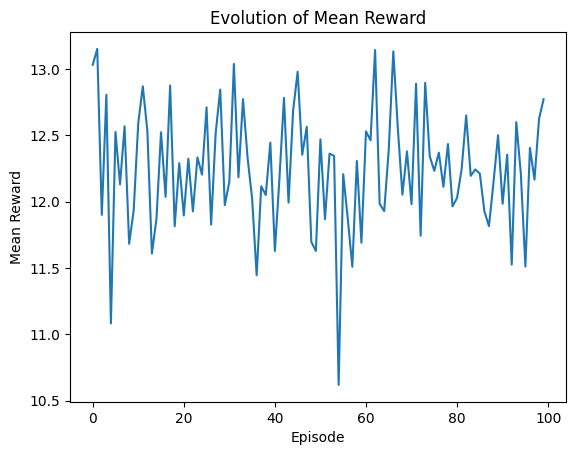

In [4]:
# Tracer l'évolution de la récompense moyenne
plt.plot(rew)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Evolution of Mean Reward')
plt.show()

In [5]:
# Après l'entraînement
torch.save(agent.actor.state_dict(), 'actor_model.pth')


In [6]:

# Avant la démonstration
agent.actor.load_state_dict(torch.load('actor_model_ed.pth'))
agent.actor.eval()  # Passer le modèle en mode évaluation

Actor(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=13, bias=True)
    (5): Tanh()
  )
)

In [7]:
env.reset()
env.get_target()
print(np.r_[env.targets[0][13], env.targets[0][16]])

loading targets from :  anaele_bent_arms_0_poppy_skeletons.pt
[ 0.12243557 -0.17011382  0.04156335 -0.13337028 -0.19293001  0.0522413 ]


In [8]:
total_reward = 0
i=0
done = False
while not done:
    i += 1
    print(i)
    action = agent.act(state)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    total_reward += reward
print("Total Reward during demonstration:", total_reward)

1
episode :  101
current step :  0
reward :  0.4594191100097319
2
episode :  101
current step :  5
reward :  0.4516971030854802
3
episode :  101
current step :  10
reward :  0.45902974132642704
4
episode :  101
current step :  15
reward :  0.475193786848172
5
episode :  101
current step :  20
reward :  0.46916108110952703
6
episode :  101
current step :  25
reward :  0.44488341703932455
7
episode :  101
current step :  30
reward :  0.47691179172869774
8
episode :  101
current step :  35
reward :  0.3103341183966122
9
episode :  101
current step :  40
reward :  0.3530342034474124
10
episode :  101
current step :  45
reward :  0.4608865469370711
11
episode :  101
current step :  50
reward :  0.427676444292153
12
episode :  101
current step :  55
reward :  0.2582629916786323
13


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons

from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym

from Poppy_Env_edouard import PoppyEnv


In [ ]:
vec_env.close()
from pypot import vrep
vrep.close_all_connections()

In [ ]:
# # Create the environment
# env = make_vec_env(lambda: PoppyEnv(), n_envs=1)

# # Initialize the agent
# model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="./sac_poppy_tensorboard/")

# # Train the agent
# total_timesteps = 3  # Set this to a higher number for better results
# model.learn(total_timesteps=total_timesteps)

# # Save the model
# model.save("sac_poppy_model")

# # Optionally evaluate the policy
# mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# print(f"Mean reward: {mean_reward} +/- {std_reward}")

# # Close the environment
# env.close()
